# Augmentation Strategies 

In this notebook we explore different augmentation strategies for neural differential equations. This time, we'll make use of the 3D `concentric spheres` dataset.

In [1]:
from torchdyn.models import *; from torchdyn.data_utils import *
from torchdyn import *

**Data**

In [2]:
# Generate 3D nested spheres data
d = ToyDataset()
X, yn = d.generate(n_samples=2**13, dataset_type='spheres')   

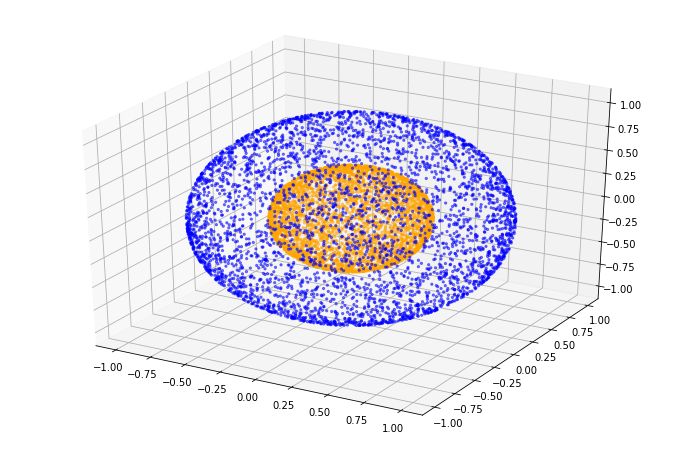

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

c = ['blue', 'orange']
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
for i in range(2):
    ax.scatter(X[yn==i,0], X[yn==i,1], X[yn==i,2], s=5, alpha=0.5, c=c[i])

In [4]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data into dataloader
bs = len(X)
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=bs, shuffle=False)

**Learner**

In [5]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, settings:dict={}):
        super().__init__()
        defaults.update(settings)
        self.settings = defaults
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)   
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

## Neural ODE (0-augmentation)

The first model under consideration involves 0-augmentation (often referred to as [ANODE](https://arxiv.org/abs/1904.01681)) and consisting in augmenting the state $h$ with additional dimensions $a$ which are initialized to 0 

$$
    \left\{
    \begin{aligned}
        \begin{bmatrix}
            \dot h(s)\\
            \dot a(s)
        \end{bmatrix} &= f([h(s), a(s)], \theta)\\
        \begin{bmatrix}
            \dot h(0)\\
            \dot a(0)
        \end{bmatrix} &= \begin{bmatrix}
            x\\
            0
        \end{bmatrix}\\
        \hat y &= Linear([h(1),a(1)])
    \end{aligned}\right.
$$

With `torchdyn`, turning a neural ODE into an ANODE is as simple as using the `Augmenter` class as follows:

In [6]:
settings = {'type':'classic', 'controlled':False, 'solver':'dopri5'}

# We consider 5 augmenting dimensions, i.e. the DEFunc must accomodate 8 inputs
func = DEFunc(nn.Sequential(nn.Linear(8,64),
                            nn.Tanh(),
                            nn.Linear(64,8))
                            )

# Define NeuralDE
neuralDE = NeuralDE(func, settings).to(device)

# Here we specify to the "Augmenter" the 5 extra dims. For 0-augmentation, we do not need to pass additional arg.s 
model = nn.Sequential(Augmenter(augment_dims=5),
                      neuralDE,
                      nn.Linear(8,2)).to(device)

Note that `Augmenter` can be fully-specified outside the neuralDE model. This makes it straightforward to switch between augmented and non-augmented at will.

In [7]:
# Train the model
learn = Learner(model, settings)
trainer = pl.Trainer(max_nb_epochs=300)
trainer.fit(learn)

INFO:lightning:
  | Name               | Type       | Params
----------------------------------------------
0 | model              | Sequential | 1 K   
1 | model.0            | Augmenter  | 0     
2 | model.1            | NeuralDE   | 1 K   
3 | model.1.defunc     | DEFunc     | 1 K   
4 | model.1.defunc.m   | Sequential | 1 K   
5 | model.1.defunc.m.0 | Linear     | 576   
6 | model.1.defunc.m.1 | Tanh       | 0     
7 | model.1.defunc.m.2 | Linear     | 520   
8 | model.1.adjoint    | Adjoint    | 0     
9 | model.2            | Linear     | 18    


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


1

**Plots**

We plot models outputs $\hat y$

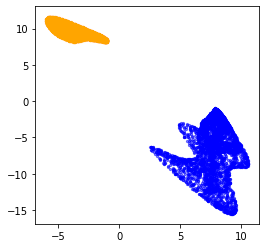

In [8]:
# Evaluate outputs
y_hat = model(X_train).detach().cpu()

# Plot results
c = ['blue', 'orange']
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
for i in range(2):
    ax.scatter(y_hat[yn==i,0], y_hat[yn==i,1], s=5, alpha=0.5, c=c[i])

## Neural ODE (Input-Layer (IL)-Augmentation) 

Input layer augmentation ([IL-augmentation](https://arxiv.org/abs/2002.08071)) is also easy to implement with `torchdyn`. 

$$
    \left\{
    \begin{aligned}
        \begin{bmatrix}
            \dot h(s)\\
            \dot a(s)
        \end{bmatrix} &= f([h(s), a(s)], \theta)\\
        \begin{bmatrix}
            \dot h(0)\\
            \dot a(0)
        \end{bmatrix} &= \begin{bmatrix}
            x\\
            g(x, \omega)
        \end{bmatrix}\\
        \hat y &= Linear([h(1),a(1)])
    \end{aligned}\right.
$$

where $g(x, \omega)$ is a neural network, usually a single linear layer.
The following is an example of a partial IL-augmentation where a linear layer is trained to determine the initial condition of the additional `5` dimensions. Notice how the `DEFunc` goes from `8` to `8` dimensions. 

In [9]:
settings = {'type':'classic', 'controlled':False, 'solver':'dopri5'}

# We consider 5 augmenting dimensions, i.e. the DEFunc must accomodate 8 inputs
func = DEFunc(nn.Sequential(nn.Linear(8,64),
                            nn.Tanh(),
                            nn.Linear(64,8))
                            )

# Define NeuralDE
neuralDE = NeuralDE(func, settings).to(device)

# Here we just need to specify to the "Augmenter" the input layer. In this case an nn.Linear(3, 5)
model = nn.Sequential(Augmenter(augment_func=nn.Linear(3, 5)),
                      neuralDE,
                      nn.Linear(8,2)).to(device)

In [10]:
# Train the model
learn = Learner(model, settings)
trainer = pl.Trainer(max_nb_epochs=300)
trainer.fit(learn)

INFO:lightning:
   | Name                 | Type       | Params
------------------------------------------------
0  | model                | Sequential | 1 K   
1  | model.0              | Augmenter  | 20    
2  | model.0.augment_func | Linear     | 20    
3  | model.1              | NeuralDE   | 1 K   
4  | model.1.defunc       | DEFunc     | 1 K   
5  | model.1.defunc.m     | Sequential | 1 K   
6  | model.1.defunc.m.0   | Linear     | 576   
7  | model.1.defunc.m.1   | Tanh       | 0     
8  | model.1.defunc.m.2   | Linear     | 520   
9  | model.1.adjoint      | Adjoint    | 0     
10 | model.2              | Linear     | 18    


1

**Plots**

We plot models outputs $\hat y$

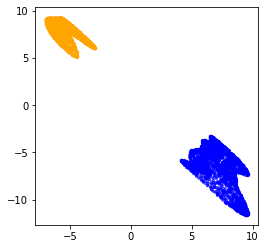

In [11]:
# Evaluate outputs
y_hat = model(X_train).detach().cpu()

# Plot results
c = ['blue', 'orange']
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
for i in range(2):
    ax.scatter(y_hat[yn==i,0], y_hat[yn==i,1], s=5, alpha=0.5, c=c[i])

**Note** that for a full `IL-augmentation`, the following model definition can replace the above. 

$$
    \left\{
    \begin{aligned}
        \begin{bmatrix}
            \dot h(s)\\
            \dot a(s)
        \end{bmatrix} &= f([h(s), a(s)], \theta)\\
        \begin{bmatrix}
            \dot h(0)\\
            \dot a(0)
        \end{bmatrix} &= g(x, \omega)\\
        \hat y &= Linear([h(1),a(1)])
    \end{aligned}\right.
$$

Determining the entire initial condition with a linear layer $g$ can be achieved without `Augmenter` as follows

In [12]:
func = DEFunc(nn.Sequential(nn.Linear(8,64),
                            nn.Tanh(),
                            nn.Linear(64,8))
                            )

neuralDE = NeuralDE(func, settings).to(device)

model = nn.Sequential(nn.Linear(3, 8),
                      neuralDE,
                      nn.Linear(8,2)).to(device)

## Neural ODE (Higher-Order Augmentation)

Finally, we take a look at increasing the order of the ODE as a method to augment the dimensions, e.g. a 2nd order neural ODE

$$
    \left\{
    \begin{aligned}
        \begin{bmatrix}
            \dot h(s)\\
            \dot a(s)
        \end{bmatrix} &= \begin{bmatrix}
           a(s)\\
           f([h(s),a(s)],\theta)
        \end{bmatrix}\\
        \begin{bmatrix}
            \dot h(0)\\
            \dot a(0)
        \end{bmatrix} &= g(x, \omega)\\
        \hat y &= Linear([h(1),a(1)])
    \end{aligned}\right.
$$

In `torchdyn`, the `DEFunc` can be specified to evolve according to higher orders by passing `func_type='higher_order` and `order=n` as arguments. `Augmenter` is still used to augment with `data dimension * n` additional dimensions.

In [13]:
settings = {'type':'higher_order', 'controlled':False, 'solver':'dopri5'}

func = DEFunc(nn.Sequential(nn.Linear(6,64),
                            nn.Tanh(),
                            nn.Linear(64,3)),
                            func_type='higher_order',
                            order=2)

neuralDE = NeuralDE(func, settings).to(device)

model = nn.Sequential(Augmenter(augment_dims=3),
                      neuralDE,
                      nn.Linear(6,2)).to(device)

In [14]:
learn = Learner(model, settings)
trainer = pl.Trainer(max_nb_epochs=300)
trainer.fit(learn)

INFO:lightning:
  | Name               | Type       | Params
----------------------------------------------
0 | model              | Sequential | 657   
1 | model.0            | Augmenter  | 0     
2 | model.1            | NeuralDE   | 643   
3 | model.1.defunc     | DEFunc     | 643   
4 | model.1.defunc.m   | Sequential | 643   
5 | model.1.defunc.m.0 | Linear     | 448   
6 | model.1.defunc.m.1 | Tanh       | 0     
7 | model.1.defunc.m.2 | Linear     | 195   
8 | model.1.adjoint    | Adjoint    | 0     
9 | model.2            | Linear     | 14    


1

**Plots**

We plot models outputs $\hat y$

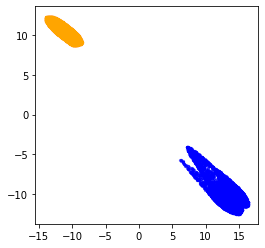

In [15]:
# Evaluate outputs
y_hat = model(X_train).detach().cpu()

# Plot results
c = ['blue', 'orange']
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
for i in range(2):
    ax.scatter(y_hat[yn==i,0], y_hat[yn==i,1], s=5, alpha=0.5, c=c[i])